# Simple droughts workflow

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=DROUGHTS_notebook_2.ipynb) to launch this workflow on MyBinder. 

This is the second and simpler drought workflow.  

Useful links:

- [Jupyter book documentation](https://jupyterbook.org/en/stable/intro.html)
- [MyST Markdown documentation](https://myst-parser.readthedocs.io/en/latest/index.html)

## Risk assessment methodology

The approach is to calculate the exposed vulnerable population to the drought. This can be done by overlying the hazard data of drought, expressed as Combined Drought Indicator (CDI), and population data. 

:::{tip} Hazard data
**The Combined Drought Indicator (CDI)** that is implemented in the European Drought Observatory (EDO) is used to identify areas affected by agricultural drought, and areas with the potential to be affected. CDI can be downloaded from the [Copernicus data server](https://edo.jrc.ec.europa.eu/gdo/php/index.php?id=2112) and is derived by combining three drought indicators produced operationally in the EDO framework - namely the 
- **Standardized Precipitation Index (SPI)**,
- **the Soil Moisture Anomaly (SMA)**, and
- **the FAPAR Anomaly** - in such a way that areas are classified according to three primary drought classes:
  1. “Watch” - indicating that precipitation is less than normal;
  2. “Warning” - indicating that soil moisture is in deficit; and
  3. “Alert” - indicating that vegetation shows signs of stress.  
  ##### Two additional classes - namely
  4. “Partial recovery” and
  5. “Recovery” - identify the stages of the vegetation recovery process. 

Standardized Precipitation Index (SPI): The SPI indicator measures precipitation anomalies at a given location, based on a comparison of observed total precipitation amounts for an accumulation period of interest (e.g. 1, 3, 12, 48 months), with the long-term historic rainfall record for that period (McKee et al., 1993; Edwards and McKee, 1997). 

Soil Moisture Anomaly (SMA): The SMA indicator is derived from anomalies of estimated daily soil moisture (or soil water) content - represented as standardized soil moisture index (SMI) - which is produced by the JRC’s LISFLOOD hydrological model, and which has been shown to be effective for drought detection purposes (Laguardia and Niemeyer, 2008).  

FAPAR Anomaly: The FAPAR Anomaly indicator is computed as deviations of the biophysical variable Fraction of Absorbed Photosynthetically Active Radiation (FAPAR), composited for 10- day intervals, from long-term mean values. Satellite-measured FAPAR represents the fraction of incident solar radiation that is absorbed by land vegetation for photosynthesis, and is effective for detecting and assessing drought impacts on vegetation canopies (Gobron et al., 2005). 

| LEVEL | COLOUR | CLASIFICATION CONDITION |
| --- | --- | --- |
| Watch | yellow | SPI-3 <-1 or SPI-1 < -2 |
| Warning | orange | SMA <-1 and (SPI-3 < -1 or SPI-1 < -2) |
| Alert | red |  <-1 and (SPI-3 < -1 or SPI-1 < -2) |



:::{list-table} Classification scheme
:widths: 15 10 40
:header-rows: 1

*   - LEVEL
    - COLOUR
    - CLASIFICATION CONDITION
*   - Watch
    - yellow
    - SPI-3 <-1 or SPI-1 < -2
*   - Warning
    - orange
    - SMA <-1 and (SPI-3 < -1 or SPI-1 < -2)
*   - Alert
    - red
    - {math}`\Delta`FAPAR < -1 and (SPI-3 < -1 or SPI-1 < -2)
*   - Partial recovery
    - brown
    - ({math}`\Delta`FAPAR < -1 and (SPI-3{sub}`m-1` < -1 or SPI-3 > -1) or\
      ({math}`\Delta`FAPAR < -1 and (SPI-1{sub}`m-1` < -2 or SPI-1 > -2)
*   - Full recovery
    - grey
    - (SPI-3{sub}`m-1` < -1 and SPI-3 > -1) or\
      (SPI-1{sub}`m-1` < -2 or SPI-1 > -2)
:::

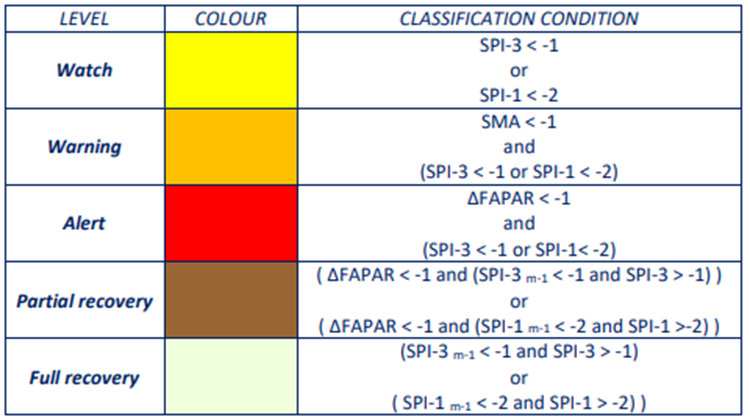

And a cell with description of the work

**Probabilistic assessment of flood damage** is calculated for different return periods (i.e. 2, 5, 10, 20, 50, 100, 250 and 500 years). In this way, damage-probability curves can be obtained at the grid cell by interpolating the damage estimates between the different recurrence intervals considered. The expected annual damages at a given grid cell due to river flooding are thus the integral of the damage-probability curve. Flood protection can be included in the expected annual damages estimation by truncating the damage-probability curves at the corresponding protection level (e.g. design flood with return period of 100 years). The integral of the remaining part after truncation quantifies the expected annual damages and expected annual population affected caused by river flooding considering flood protection up to the design flood.  
Similar to flood damages, population exposure probability functions can be derived for each grid cell within the modelled domain.  

## Preparation work

### Load libraries

In this notebook we will use the following Python libraries:

**Replace the libraries in the next two cells with the libraries used in the workflow**

### Load libraries

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
- [matplotlib](https://matplotlib.org/) - For plotting as well

In [10]:
import os
import pooch

import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'my_workflow' in the same directory where this notebook is saved.


:::{tip} Don't forget!
Replace **my_workflow** with the workflow name and delete this note
:::


In [2]:
workflow_folder = 'my_workflow'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

### Download data

**You can keep the text below if you want to use pooch for downloading. Otherwise add a text about the API and delete the pooch bit.**

The data we are using is available as compressed ZIP files in the JRC data portal. 
Since there is no API to download this data, we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library to donwload and unzip the data.  

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

In [3]:
data_dir = os.path.join(workflow_folder,'data')

Note that now we have a directory **my_workflow/data** where all the zip files and unzipped flood files are.  
We can list all the files in the **data_dir** using the os library.  

In [ ]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

#### First type of data
First we need the information on land use. We will download it from the JRC data portal.
:::{tip} Here's an example of the text and code
Once the data is downloaded and unzipped, Pooch will list the content of the directory with the data.

```python
url = 'https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/PrimaryOutput/Europe/REF-2014/JRC_LUISA_Output_land_use_ref_2014.zip'
pooch.retrieve(
    url=url,
    known_hash=None,
    path=data_dir,
    processor=pooch.Unzip(extract_dir='')
)
```

:::

## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### Some data I
Add text about your data here.

Explain the folder structure and file names.

All the downloaded files are stored in our **data_dir** folder, with filenames starting with: ...  
First we can explore one of them.

:::{tip} Explore the file content
Fell free to explore the content and structure of the datasets.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics👆 (click)
:class: dropdown
👋 Click on **spatial_ref** 📄 _show/hide attributes_ to see the spatial information  
👋 Look at _STATISTICS_ attributes to find minimum, maximum and other statistics

:::

In [2]:
# code here to open and show the data

### Some data II
Add text about other dataset you are using here.  

If there are more files in the directory, you can list the directory and explain what is what.

In [ ]:
#with os.scandir(f'{data_dir}/other_data') as entries:
#    for entry in entries:
#        print(entry.name)

Let's explore one of the dataset files, for example this one...  
Write which library is used, especially if it is different from other datasets.

In [3]:
# code here to open and show the data

## Process the data

Explain why the processing is needed. For example:
- if the data is global, we might need to crop all the datasets to the area of interest, set the coordinates of the bounding box in a separate cell
- if datasets have different resolution and projection we need to reproject one of them and interpolate to the same resolution in order to be able to do computations.
- try to use areas of one of the pilots in the examples

Explain which libraries are used in this step and why.

:::{tip} Here's an example text:

If we have a closer look at the x and y dimensions of the datasets, we can see that the data has different resolutions. Flood extent maps are at 100 m resolution, while land use data is at 1km. We can use xarray to get them to the same resolution.  

But first we need to clip them to the same area, so we don't interpolate the whole global field.   

For this we use the rioxarray library again.  
**minx** and **maxx** are longitudes, and **miny** and **maxy** are latitudes of the bounding box.  

In this example we are clipping the bounding box around city of Zilina in Slovakia.
:::

In [6]:
xmin=18
ymin=48
xmax=20
ymax=50

In [4]:
# code cell with processing

#### Explanation of the processing step I

Explain the processing step, what library is used and why.  
Try to include links to the documentation about the functions you are using.

:::{tip} Here's an example text:
#### Interpolate the land use data array

Next we need to interpolate the land use data into the flood map grid in order to be able to calculate the damage map.  
We can use the xarray [**interp_like()**](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp_like.html) function, that will interpolate the land use data into flood grid.  

Since we don't really want interpolate the values, we are using method **'nearest'**, to assing the values of the nearest grid points.

:::

In [5]:
# code cell with processing, for example:
#flood_200_small_area_1km  = flood_200_small_area.interp_like(land_use_small_area, method='nearest')
#flood_200_small_area_1km

You may include a simple plot to quickly visualise the result. But make sure to explain what is plotted

In [6]:
#flood_200_small_area_1km.plot()

## Calculate the indices

Calculating some indices using the processed data is often part of the workflow. 

- Explain here what is calculated, include the links to the documentation about the methond.
- Explain what libraries are used and include link to the documentation
- Explain clearly what input fields are
- Explain which functions are used and possibly their parameters
- Explain what the output is

In [8]:
# code for the calculation

In [7]:
# another code cell

## Plot the results

Plot the results. Explain what libray is used and provide the link if it is not already there.

If the plotting code is large, break it into more cells and explain each part.

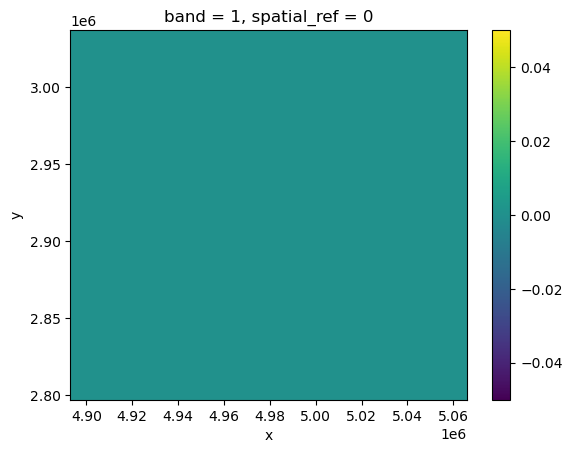

In [31]:
damagemap = rxr.open_rasterio('scenario_damagemap.tif')
damagemap.plot()

## Conclusions

Some text about conclusions and lessons learned

## Contributors
authors, links to libraries documentation, references etc